# Tissue Morphing

## Notebook purpose

The purpose of this notebook is to implement and explore tissue morphing across sequential images, creating an intermediate representation of tissue layers. In this notebook, we will take consecutive images of tissue samples and generate smooth transitions between them, effectively constructing intermediate states that represent gradual morphological changes.

## Imports

- MiMorph: Implementation of previous pipeline steps.
- Matplotlib: Visualisation.
- OpenCV(cv2): Tools for morphing and processing images.

In [1]:
from mimorph import tissue_classes
from mimorph import *
import sys
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Data Import

In [2]:
sys.modules['tissue_classes'] = tissue_classes

load_path = Path('../data/')
to_load = ['slide_1.pkl', 'slide_2.pkl']
slides = []

for file_path in load_path.glob('*.pkl'):
    if file_path.name in to_load:
        with open(file_path, 'rb') as f:
            print(f'Loading {file_path}...')
            obj = pickle.load(f)
            slides.append(obj)

Loading ..\data\slide_1.pkl...
Loading ..\data\slide_2.pkl...


## Registration

In this section, consecutive tissue images within each slide are aligned using a registration procedure. For each slide, the code iterates over the tissue images, performing two types of registration. First, a training registration is performed between every other image to establish robust transformations for the morphing process. Second, a validation registration is carried out between consecutive images to provide a real reference for evaluating the morphing results. This valid image serves as a benchmark to check whether the tissue generated by morphing closely resembles the actual transformed tissue.

### Helper Functions

`register` - Wrapper to registration provided from previous notebooks.
`copy_tissue` - Creates new tissue object with given item.

In [3]:
affine_register = TissueAffineRegister('../data/params/optuna_affine_2025-08-23_22-48-43.json')
non_affine_register = TissueNonAffineRegister('../data/params/optuna_non_affine_2025-08-24_02-32-01.json')

def copy_tissue(t):
    return Tissue(t.he, t.rgb, t.mask)

def register(t1, t2):
    t2_reg = affine_register.register(t1, t2)
    t2_reg = non_affine_register.register(t1, t2_reg)

    return t2_reg

Loading parameters from file: ../data/params/optuna_affine_2025-08-23_22-48-43.json ...
Loading parameters from file: ../data/params/optuna_non_affine_2025-08-24_02-32-01.json ...


### Prepare morphing data

In [4]:
data = []

for j, slide in enumerate(slides):
    print(f'Slide {j+1}/{len(slides)}:')
    reg_slide = {}
    for i in range(0, len(slide)-2):
        reg_slide['t1'] = copy_tissue(slide[i])
        print(f'   Registering({i+1}/{len(slide)-2}) {i} -> {i+2} (training)')
        reg_slide['t2'] = register(slide[i], slide[i+2])
        print(f'   Registering({i+1}/{len(slide)-2}) {i} -> {i+1} (validation)')
        reg_slide['valid'] = register(slide[i], slide[i+1])
    data.append(reg_slide)

Slide 1/2:
   Registering(1/1) 0 -> 2 (training)
   Registering(1/1) 0 -> 1 (validation)
Slide 2/2:
   Registering(1/2) 0 -> 2 (training)
   Registering(1/2) 0 -> 1 (validation)
   Registering(2/2) 1 -> 3 (training)
   Registering(2/2) 1 -> 2 (validation)


## Morphing


### Helper functions

In [14]:
def img_float(img):
    img_float = img.astype(np.float32)
    
    if img_float.max() > 1.0:
        img_float /= 255.0
    
    return img_float

def img_uint(img):
    if img.max() <= 1.0:
        img_uint = (img * 255).astype(np.uint8)
    else:
        img_uint = img.astype(np.uint8)
    
    return img_uint

def morph(index, algorithm, morph_rgb: bool = False):
    assert index < len(data)
    
    def morph_img(img1, img2):
        return img_uint(algorithm(img_float(img1), img_float(img2)))
    
    t1, t2 = data[index]['t1'], data[index]['t2']
    he_morph = morph_img(t1.he, t2.he)

    if morph_rgb:
        rgb_morph = morph_img(t1.rgb, t2.rgb)
    else:
        rgb_morph = np.zeros_like(t1.rgb)
    return Tissue(he=he_morph, rgb=rgb_morph, mask=tissue_create_mask(he_morph))

### Metric

In [18]:
def scaled_mse(morph, valid, mask):
    diff = (morph - valid) ** 2
    return diff[mask].mean()

def sharpness_laplacian(morph, valid, mask):
    return cv2.Laplacian(morph.astype(np.float64), cv2.CV_64F)[mask].var()

metrics = {
    'MSE': scaled_mse,
    'Laplacian': sharpness_laplacian
}

def morph_metric(index, result, mask_diff = True):
    assert index < len(data)

    def it(img):
        return np.moveaxis(img, 2, 0)
    def score_img(img1, img2, mask, score_func):
        return score_func(img_float(img1), img_float(img2), mask)
    
    valid = data[index]['valid']
    metric_mask = np.logical_or(result.mask, valid.mask)
    
    scores = {}
    if mask_diff:
        mask_difference = np.logical_xor(result.mask, valid.mask).sum()
        scores['Mask_difference'] = mask_difference

    for name, metric in metrics.items():
        values = []
        
        for result_ch, valid_ch in zip(it(result.he), it(valid.he)):
            values.append(score_img(result_ch, valid_ch, metric_mask, metric))
        
        scores[name] = sum(values)/len(values)

    return scores

### Plot Morph

In [19]:
def plot_channel_diff(index, result, title=''):
    valid = data[index]['valid']
    hem1, hem2 = result.hem, valid.hem
    eos1, eos2 = result.eos, valid.eos

    fig, axes = plt.subplots(2, 2, figsize=(10,10))
    fig.suptitle(title, fontsize=20)
    axes[0,0].set_title('Morphed')
    axes[0,0].imshow(result.eos)
    axes[0,1].set_title('Validation')
    axes[0,1].imshow(valid.rgb)
    axes[1,0].set_title('Hematoxylin')
    axes[1,0].imshow(cv2.absdiff(hem1, hem2), cmap='magma')
    axes[1,1].set_title('Eosine')
    axes[1,1].imshow(cv2.absdiff(eos1, eos2), cmap='magma')
    for ax in axes.flatten():
        ax.axis('off')
    plt.show()

### Linear Cross-Dissolve

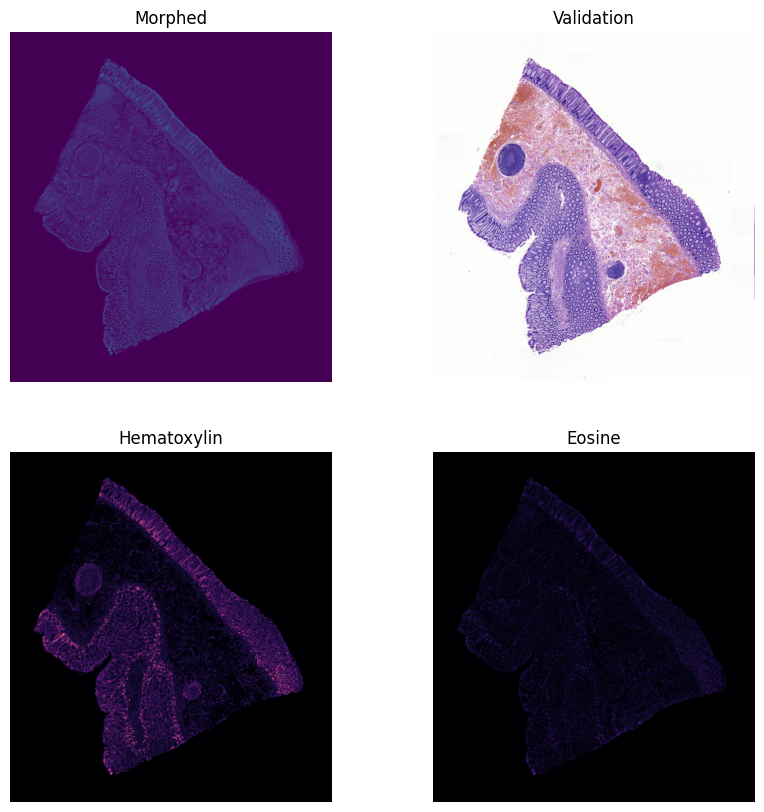

{'Mask_difference': np.int64(4201235), 'MSE': np.float32(0.003290073), 'Laplacian': np.float64(0.0027680012905880193)}


In [22]:
def linear_morph(img1, img2):
    alpha = 0.5
    blended = (1 - alpha) * img1 + alpha * img2
    return np.clip(blended, 0, 1)

index = 0
result = morph(index, linear_morph, True)
plot_channel_diff(index, result)

linear_metrics = morph_metric(index, result)
print(linear_metrics)

### Optical flow

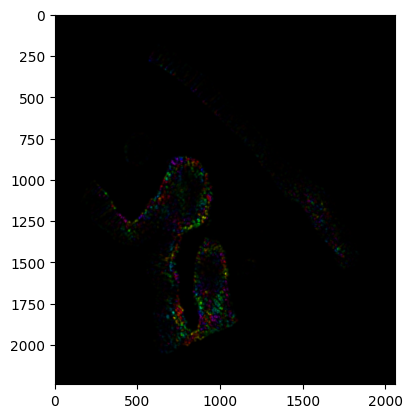

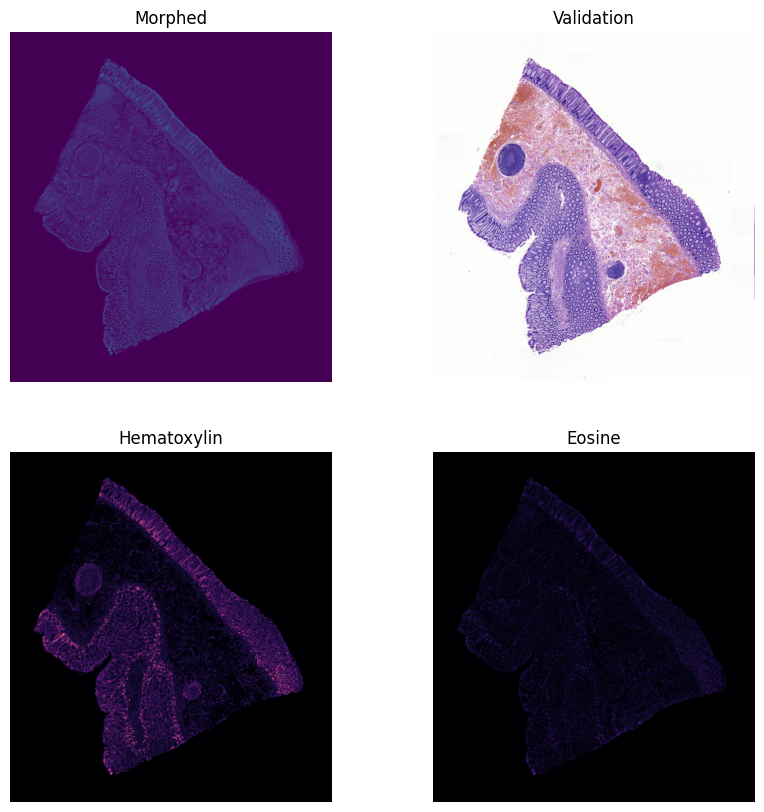

{'Mask_difference': np.int64(4201235), 'MSE': np.float32(0.003290073), 'Laplacian': np.float64(0.0027680012905880193)}


In [ ]:
def optical_flow_morph(t1, t2):
    alpha=0.5

    if t1.ndim == 2:
        t1 = t1[..., np.newaxis]
        t2 = t2[..., np.newaxis]

    flows = []
    for c in range(t1.shape[-1]):
        img1_gray = t1[..., c]
        img2_gray = t2[..., c]

        flow = cv2.calcOpticalFlowFarneback(
            img1_gray.astype(np.float32),
            img2_gray.astype(np.float32),
            None,
            pyr_scale=0.5, levels=3, winsize=15,
            iterations=3, poly_n=5, poly_sigma=1.2, flags=0
        )
        flows.append(flow)

    avg_flow = np.mean(flows, axis=0)

    h, w = t1.shape[:2]
    map_x, map_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (map_x + alpha * avg_flow[...,0]).astype(np.float32)
    map_y = (map_y + alpha * avg_flow[...,1]).astype(np.float32)

    warped = np.zeros_like(t1, dtype=np.float32)
    for c in range(t1.shape[-1]):
        warped[...,c] = cv2.remap(t1[...,c], map_x, map_y, interpolation=cv2.INTER_LINEAR)

    blended = (1 - alpha) * warped + alpha * t2
    return blended

index = 0
result = morph(index, optical_flow_morph)
plot_channel_diff(index, result)

of_metrics = morph_metric(index, result)
print(of_metrics)